In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

from skimage.morphology import closing, square
from tools import *
from plot import *

In [2]:
indiana_img = np.load('../data/indianapines.npy')
indiana_labels = np.load('../data/indianapines_gt.npy')
salinas_img = np.load('../data/salinas.npy')
salinas_labels = np.load('../data/salinas_gt.npy')

In [3]:
# normalize radiance values to get reflectance values
indiana_img = indiana_img / indiana_img.max()
salinas_img = salinas_img / salinas_img.max()

In [4]:
print("Indiana shape: {}".format(indiana_img.shape))
print("Salinas shape: {}".format(salinas_img.shape))

Indiana shape: (145, 145, 200)
Salinas shape: (512, 217, 204)


In [5]:
X_indiana = indiana_img.reshape((-1, indiana_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Indiana shape: {}".format(X_indiana.shape))

X_salinas = salinas_img.reshape((-1, salinas_img.shape[-1])) # reshaping the HSI as a 2D matrix
print("Salinas shape: {}".format(X_salinas.shape))

Indiana shape: (21025, 200)
Salinas shape: (111104, 204)


In [6]:
n_cluster_indiana = len(np.unique(indiana_labels)) - 1
n_cluster_salinas = len(np.unique(salinas_labels)) - 1

In [8]:
indiana_class_names = np.arange(n_cluster_indiana).astype(str)
salinas_class_names = np.arange(n_cluster_salinas).astype(str)

## Remove unclassified data

In [9]:
X_indiana, X_indiana_idx = remove_unclassified_input(X_indiana, indiana_labels)
X_salinas, X_salinas_idx = remove_unclassified_input(X_salinas, salinas_labels)

In [10]:
print(X_indiana.shape)
print(X_indiana_idx.shape)
print(X_salinas.shape)

(10249, 200)
(10249,)
(54129, 204)


In [11]:
indiana_labels, _ = remove_unclassified_input(indiana_labels.flatten(), indiana_labels)
salinas_labels, _ = remove_unclassified_input(salinas_labels.flatten(), salinas_labels)

In [12]:
print(indiana_labels.shape)
print(salinas_labels.shape)

(10249,)
(54129,)


## PCA

In [13]:
n_components_indiana = get_number_components(X_indiana)
n_components_salinas = get_number_components(X_salinas)

Fitting the PCA
Fitting the PCA


In [14]:
print("Number of components Indiana: {}".format(n_components_indiana))
print("Number of components Salinas: {}".format(n_components_salinas))

Number of components Indiana: 68
Number of components Salinas: 5


In [15]:
X_indiana_reduced = extract_features(X_indiana, n_components_indiana)
X_salinas_reduced = extract_features(X_salinas, n_components_salinas)

In [16]:
print("Indiana reduced data shape: {}".format(X_indiana_reduced.shape))
print("Salinas reduced data shape: {}".format(X_salinas_reduced.shape))

Indiana reduced data shape: (10249, 68)
Salinas reduced data shape: (54129, 5)


## Split train / test

In [17]:
# shuffle manually
X_indiana_shuffle, indiana_labels_shuffle, shuffle_arr_indiana = shuffle(X_indiana_reduced, indiana_labels)
X_salinas_shuffle, salinas_labels_shuffle, shuffle_arr_salinas = shuffle(X_salinas_reduced, salinas_labels)

# shuffle index
#X_indiana_idx[np.arange(indiana_labels_shuffle.size)] = X_indiana_idx[shuffle_arr]

In [18]:
unmapping_shuffle_indiana = np.empty(shuffle_arr_indiana.size,  dtype=int)
unmapping_shuffle_indiana[shuffle_arr_indiana] = np.arange(shuffle_arr_indiana.size)

In [19]:
# nb_test = int(X_indiana_shuffle.shape[0] * 0.25)
# X_train_indiana = X_indiana_shuffle[nb_test:]
# y_train_indiana = indiana_labels_shuffle[nb_test:]
# X_test_indiana = X_indiana_shuffle[:nb_test]
# y_test_indiana = indiana_labels_shuffle[:nb_test]

In [20]:
y_indiana_labels_argsort = np.argsort(indiana_labels_shuffle)
y_salinas_labels_argsort = np.argsort(salinas_labels_shuffle)

In [21]:
#unmapping_argsort = np.argsort(y_indiana_labels_argsort)

In [22]:
for i in range(1, n_cluster_indiana + 1):
    print(indiana_labels_shuffle[indiana_labels_shuffle == i].size)    

46
1428
830
237
483
730
28
478
20
972
2455
593
205
1265
386
93


In [23]:
labels_indiana, count_indiana = np.unique(indiana_labels_shuffle-1, return_counts=True)
labels_salinas, count_salinas = np.unique(salinas_labels_shuffle-1, return_counts=True)

In [24]:
x_train_indiana, x_test_indiana, y_train_indiana_labels, y_test_indiana_labels = split_x_train_test(X_indiana_shuffle, count_indiana, labels_indiana, y_indiana_labels_argsort, (0, n_components_indiana))

Cluster: 0
Nb total samples: 46
Nb samples train: 34
Nb samples test: 12
---------------
Cluster: 1
Nb total samples: 1428
Nb samples train: 1071
Nb samples test: 357
---------------
Cluster: 2
Nb total samples: 830
Nb samples train: 622
Nb samples test: 208
---------------
Cluster: 3
Nb total samples: 237
Nb samples train: 177
Nb samples test: 60
---------------
Cluster: 4
Nb total samples: 483
Nb samples train: 362
Nb samples test: 121
---------------
Cluster: 5
Nb total samples: 730
Nb samples train: 547
Nb samples test: 183
---------------
Cluster: 6
Nb total samples: 28
Nb samples train: 21
Nb samples test: 7
---------------
Cluster: 7
Nb total samples: 478
Nb samples train: 358
Nb samples test: 120
---------------
Cluster: 8
Nb total samples: 20
Nb samples train: 15
Nb samples test: 5
---------------
Cluster: 9
Nb total samples: 972
Nb samples train: 729
Nb samples test: 243
---------------
Cluster: 10
Nb total samples: 2455
Nb samples train: 1841
Nb samples test: 614
-----------

In [25]:
x_train_salinas, x_test_salinas, y_train_salinas_labels, y_test_salinas_labels = split_x_train_test(X_salinas_shuffle, count_salinas, labels_salinas, y_salinas_labels_argsort, (0, n_components_salinas))

Cluster: 0
Nb total samples: 2009
Nb samples train: 1506
Nb samples test: 503
---------------
Cluster: 1
Nb total samples: 3726
Nb samples train: 2794
Nb samples test: 932
---------------
Cluster: 2
Nb total samples: 1976
Nb samples train: 1482
Nb samples test: 494
---------------
Cluster: 3
Nb total samples: 1394
Nb samples train: 1045
Nb samples test: 349
---------------
Cluster: 4
Nb total samples: 2678
Nb samples train: 2008
Nb samples test: 670
---------------
Cluster: 5
Nb total samples: 3959
Nb samples train: 2969
Nb samples test: 990
---------------
Cluster: 6
Nb total samples: 3579
Nb samples train: 2684
Nb samples test: 895
---------------
Cluster: 7
Nb total samples: 11271
Nb samples train: 8453
Nb samples test: 2818
---------------
Cluster: 8
Nb total samples: 6203
Nb samples train: 4652
Nb samples test: 1551
---------------
Cluster: 9
Nb total samples: 3278
Nb samples train: 2458
Nb samples test: 820
---------------
Cluster: 10
Nb total samples: 1068
Nb samples train: 801


In [26]:
print("Train shape: {}".format(x_train_indiana.shape))
print("Train labels shape: {}".format(y_train_indiana_labels.shape))
print("Test shape: {}".format(x_test_indiana.shape))
print("Test labels shape: {}".format(y_test_indiana_labels.shape))

Train shape: (7680, 68)
Train labels shape: (7680,)
Test shape: (2569, 68)
Test labels shape: (2569,)


In [27]:
print("Train shape: {}".format(x_train_salinas.shape))
print("Train labels shape: {}".format(y_train_salinas_labels.shape))
print("Test shape: {}".format(x_test_salinas.shape))
print("Test labels shape: {}".format(y_test_salinas_labels.shape))

Train shape: (40592, 5)
Train labels shape: (40592,)
Test shape: (13537, 5)
Test labels shape: (13537,)


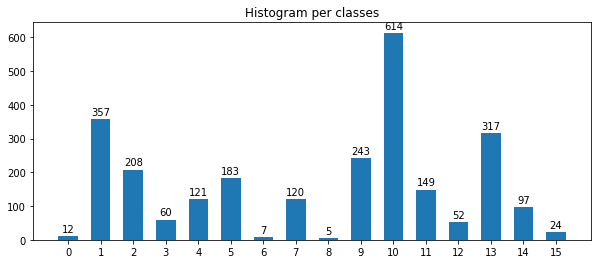

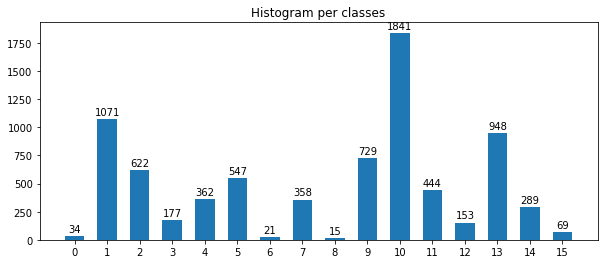

In [28]:
plot_histogram(y_test_indiana_labels)
plot_histogram(y_train_indiana_labels)

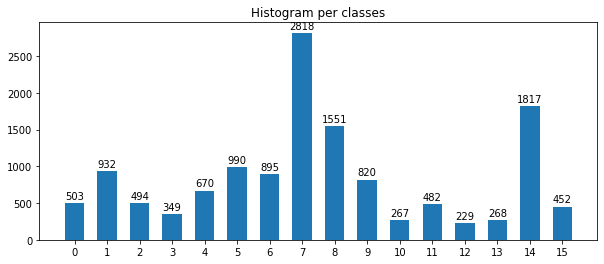

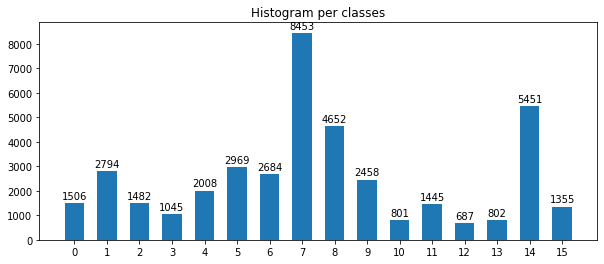

In [29]:
plot_histogram(y_test_salinas_labels)
plot_histogram(y_train_salinas_labels)

## Random Forest

In [30]:
modelRF_indiana = RandomForestClassifier(n_estimators=100, verbose=1, n_jobs=8)
modelRF_salinas = RandomForestClassifier(n_estimators=100, verbose=1, n_jobs=8)

In [31]:
modelRF_indiana.fit(x_train_indiana, y_train_indiana_labels)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.2s finished


RandomForestClassifier(n_jobs=8, verbose=1)

In [32]:
modelRF_salinas.fit(x_train_salinas, y_train_salinas_labels)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


RandomForestClassifier(n_jobs=8, verbose=1)

In [33]:
# training score
modelRF_indiana.score(x_train_indiana, y_train_indiana_labels)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


1.0

In [34]:
# training score
modelRF_salinas.score(x_train_salinas, y_train_salinas_labels)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


1.0

In [35]:
modelRF_indiana.verbose = 0
for cluster in labels_indiana:
    idxs = np.argwhere(y_train_indiana_labels == cluster).flatten()
    score = modelRF_indiana.score(x_train_indiana[idxs], y_train_indiana_labels[idxs])
    print("Cluster: {}".format(cluster))
    print("Nb samples: {}".format(y_train_indiana_labels[idxs].size))
    print("Score: {}".format(score))
    print("-----------")

Cluster: 0
Nb samples: 34
Score: 1.0
-----------
Cluster: 1
Nb samples: 1071
Score: 1.0
-----------
Cluster: 2
Nb samples: 622
Score: 1.0
-----------
Cluster: 3
Nb samples: 177
Score: 1.0
-----------
Cluster: 4
Nb samples: 362
Score: 1.0
-----------
Cluster: 5
Nb samples: 547
Score: 1.0
-----------
Cluster: 6
Nb samples: 21
Score: 1.0
-----------
Cluster: 7
Nb samples: 358
Score: 1.0
-----------
Cluster: 8
Nb samples: 15
Score: 1.0
-----------
Cluster: 9
Nb samples: 729
Score: 1.0
-----------
Cluster: 10
Nb samples: 1841
Score: 1.0
-----------
Cluster: 11
Nb samples: 444
Score: 1.0
-----------
Cluster: 12
Nb samples: 153
Score: 1.0
-----------
Cluster: 13
Nb samples: 948
Score: 1.0
-----------
Cluster: 14
Nb samples: 289
Score: 1.0
-----------
Cluster: 15
Nb samples: 69
Score: 1.0
-----------


In [36]:
modelRF_salinas.verbose = 0
for cluster in labels_salinas:
    idxs = np.argwhere(y_train_salinas_labels == cluster).flatten()
    score = modelRF_salinas.score(x_train_salinas[idxs], y_train_salinas_labels[idxs])
    print("Cluster: {}".format(cluster))
    print("Nb samples: {}".format(y_train_salinas_labels[idxs].size))
    print("Score: {}".format(score))
    print("-----------")

Cluster: 0
Nb samples: 1506
Score: 1.0
-----------
Cluster: 1
Nb samples: 2794
Score: 1.0
-----------
Cluster: 2
Nb samples: 1482
Score: 1.0
-----------
Cluster: 3
Nb samples: 1045
Score: 1.0
-----------
Cluster: 4
Nb samples: 2008
Score: 1.0
-----------
Cluster: 5
Nb samples: 2969
Score: 1.0
-----------
Cluster: 6
Nb samples: 2684
Score: 1.0
-----------
Cluster: 7
Nb samples: 8453
Score: 1.0
-----------
Cluster: 8
Nb samples: 4652
Score: 1.0
-----------
Cluster: 9
Nb samples: 2458
Score: 1.0
-----------
Cluster: 10
Nb samples: 801
Score: 1.0
-----------
Cluster: 11
Nb samples: 1445
Score: 1.0
-----------
Cluster: 12
Nb samples: 687
Score: 1.0
-----------
Cluster: 13
Nb samples: 802
Score: 1.0
-----------
Cluster: 14
Nb samples: 5451
Score: 1.0
-----------
Cluster: 15
Nb samples: 1355
Score: 1.0
-----------


In [37]:
# testing score
modelRF_indiana.score(x_test_indiana, y_test_indiana_labels)

0.8127676138575322

In [38]:
# testing score
modelRF_salinas.score(x_test_salinas, y_test_salinas_labels)

0.9359533131417597

In [39]:
mean_score = 0
for cluster in labels_indiana:
    idxs = np.argwhere(y_test_indiana_labels == cluster).flatten()
    score = modelRF_indiana.score(x_test_indiana[idxs], y_test_indiana_labels[idxs])
    mean_score += score
    print("Cluster: {}".format(cluster))
    print("Nb samples: {}".format(y_test_indiana_labels[idxs].size))
    print("Score: {}".format(score))
    print("-----------")
    
mean_score /= len(labels_indiana)
print(mean_score)

Cluster: 0
Nb samples: 12
Score: 0.5833333333333334
-----------
Cluster: 1
Nb samples: 357
Score: 0.7563025210084033
-----------
Cluster: 2
Nb samples: 208
Score: 0.5384615384615384
-----------
Cluster: 3
Nb samples: 60
Score: 0.3333333333333333
-----------
Cluster: 4
Nb samples: 121
Score: 0.9338842975206612
-----------
Cluster: 5
Nb samples: 183
Score: 0.9836065573770492
-----------
Cluster: 6
Nb samples: 7
Score: 0.8571428571428571
-----------
Cluster: 7
Nb samples: 120
Score: 1.0
-----------
Cluster: 8
Nb samples: 5
Score: 0.0
-----------
Cluster: 9
Nb samples: 243
Score: 0.7407407407407407
-----------
Cluster: 10
Nb samples: 614
Score: 0.9022801302931596
-----------
Cluster: 11
Nb samples: 149
Score: 0.610738255033557
-----------
Cluster: 12
Nb samples: 52
Score: 0.9615384615384616
-----------
Cluster: 13
Nb samples: 317
Score: 0.9716088328075709
-----------
Cluster: 14
Nb samples: 97
Score: 0.5567010309278351
-----------
Cluster: 15
Nb samples: 24
Score: 0.9583333333333334
------

In [40]:
mean_score = 0
for cluster in labels_salinas:
    idxs = np.argwhere(y_test_salinas_labels == cluster).flatten()
    score = modelRF_salinas.score(x_test_salinas[idxs], y_test_salinas_labels[idxs])
    mean_score += score
    print("Cluster: {}".format(cluster))
    print("Nb samples: {}".format(y_test_salinas_labels[idxs].size))
    print("Score: {}".format(score))
    print("-----------")
    
mean_score /= len(labels_salinas)
print(mean_score)

Cluster: 0
Nb samples: 503
Score: 0.9980119284294234
-----------
Cluster: 1
Nb samples: 932
Score: 0.9967811158798283
-----------
Cluster: 2
Nb samples: 494
Score: 0.9919028340080972
-----------
Cluster: 3
Nb samples: 349
Score: 0.9799426934097422
-----------
Cluster: 4
Nb samples: 670
Score: 0.9880597014925373
-----------
Cluster: 5
Nb samples: 990
Score: 0.997979797979798
-----------
Cluster: 6
Nb samples: 895
Score: 0.9966480446927374
-----------
Cluster: 7
Nb samples: 2818
Score: 0.8924769339957417
-----------
Cluster: 8
Nb samples: 1551
Score: 0.9980657640232108
-----------
Cluster: 9
Nb samples: 820
Score: 0.9524390243902439
-----------
Cluster: 10
Nb samples: 267
Score: 0.9775280898876404
-----------
Cluster: 11
Nb samples: 482
Score: 1.0
-----------
Cluster: 12
Nb samples: 229
Score: 1.0
-----------
Cluster: 13
Nb samples: 268
Score: 0.9514925373134329
-----------
Cluster: 14
Nb samples: 1817
Score: 0.740231150247661
-----------
Cluster: 15
Nb samples: 452
Score: 0.993362831858

In [41]:
preds_indiana = modelRF_indiana.predict(X_indiana_reduced)

In [42]:
preds_salinas = modelRF_salinas.predict(X_salinas_reduced)

### Classification report on test & train

In [43]:
preds_indiana_test = modelRF_indiana.predict(x_test_indiana)
preds_indiana_train = modelRF_indiana.predict(x_train_indiana)

In [46]:
print(classification_report(y_train_indiana_labels, preds_indiana_train, target_names=indiana_class_names))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00      1071
           2       1.00      1.00      1.00       622
           3       1.00      1.00      1.00       177
           4       1.00      1.00      1.00       362
           5       1.00      1.00      1.00       547
           6       1.00      1.00      1.00        21
           7       1.00      1.00      1.00       358
           8       1.00      1.00      1.00        15
           9       1.00      1.00      1.00       729
          10       1.00      1.00      1.00      1841
          11       1.00      1.00      1.00       444
          12       1.00      1.00      1.00       153
          13       1.00      1.00      1.00       948
          14       1.00      1.00      1.00       289
          15       1.00      1.00      1.00        69

    accuracy                           1.00      7680
   macro avg       1.00   

In [48]:
print(classification_report(y_test_indiana_labels, preds_indiana_test, target_names=indiana_class_names))

              precision    recall  f1-score   support

           0       1.00      0.58      0.74        12
           1       0.74      0.76      0.75       357
           2       0.80      0.54      0.64       208
           3       0.77      0.33      0.47        60
           4       0.93      0.93      0.93       121
           5       0.87      0.98      0.93       183
           6       0.86      0.86      0.86         7
           7       0.94      1.00      0.97       120
           8       0.00      0.00      0.00         5
           9       0.78      0.74      0.76       243
          10       0.75      0.90      0.82       614
          11       0.81      0.61      0.70       149
          12       0.96      0.96      0.96        52
          13       0.91      0.97      0.94       317
          14       0.77      0.56      0.65        97
          15       0.92      0.96      0.94        24

    accuracy                           0.81      2569
   macro avg       0.80   

/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sabine/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
preds_salinas_test = modelRF_salinas.predict(x_test_salinas)
preds_salinas_train = modelRF_salinas.predict(x_train_salinas)

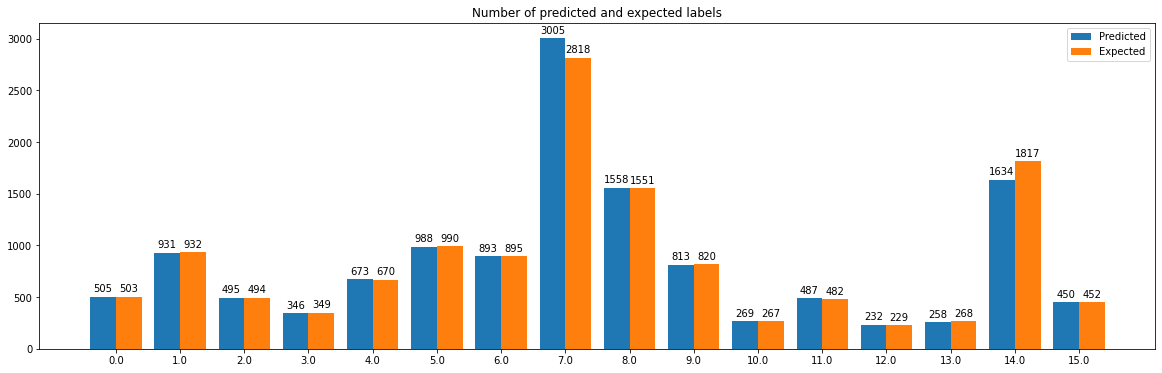

In [82]:
plot_histogram_compare_predict_expect(preds_salinas_test, y_test_salinas_labels)

In [83]:
print(classification_report(preds_salinas_train, y_train_salinas_labels, target_names=salinas_class_names))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1506
           1       1.00      1.00      1.00      2794
           2       1.00      1.00      1.00      1482
           3       1.00      1.00      1.00      1045
           4       1.00      1.00      1.00      2008
           5       1.00      1.00      1.00      2969
           6       1.00      1.00      1.00      2684
           7       1.00      1.00      1.00      8453
           8       1.00      1.00      1.00      4652
           9       1.00      1.00      1.00      2458
          10       1.00      1.00      1.00       801
          11       1.00      1.00      1.00      1445
          12       1.00      1.00      1.00       687
          13       1.00      1.00      1.00       802
          14       1.00      1.00      1.00      5451
          15       1.00      1.00      1.00      1355

    accuracy                           1.00     40592
   macro avg       1.00   

In [84]:
print(classification_report(preds_salinas_test, y_test_salinas_labels, target_names=salinas_class_names))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       505
           1       1.00      1.00      1.00       931
           2       0.99      0.99      0.99       495
           3       0.98      0.99      0.98       346
           4       0.99      0.98      0.99       673
           5       1.00      1.00      1.00       988
           6       1.00      1.00      1.00       893
           7       0.89      0.84      0.86      3005
           8       1.00      0.99      1.00      1558
           9       0.95      0.96      0.96       813
          10       0.98      0.97      0.97       269
          11       1.00      0.99      0.99       487
          12       1.00      0.99      0.99       232
          13       0.95      0.99      0.97       258
          14       0.74      0.82      0.78      1634
          15       0.99      1.00      1.00       450

    accuracy                           0.94     13537
   macro avg       0.97   

In [85]:
#preds_test = y_test_indiana_labels
#preds_train = y_train_indiana_labels

In [86]:
print(indiana_labels.shape)
print(preds_indiana.shape)

(10249,)
(10249,)


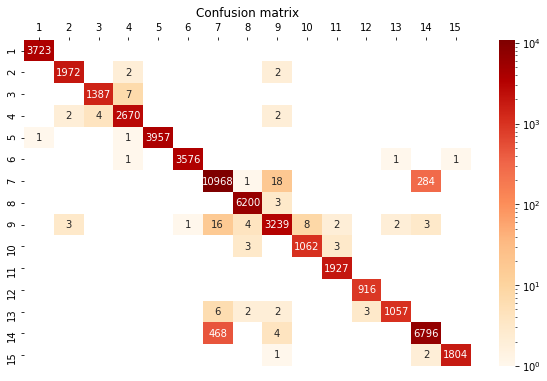

In [87]:
plot_confusion_matrix(salinas_labels, preds_salinas + 1, class_names=np.arange(1, 16), log=True)

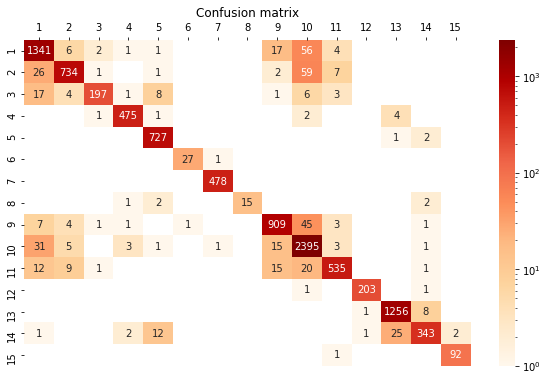

In [88]:
plot_confusion_matrix(indiana_labels, preds_indiana + 1, class_names=np.arange(1, 16), log=True)

In [89]:
#sum_train = 0
#sum_test = 0

#preds_indiana = np.empty([])
#y_indiana_labels = np.array([])

#for cluster in labels:
#    idx = int(count[cluster] * 0.75)
    
#    preds_indiana = np.hstack((preds_indiana, preds_train[sum_train:sum_train+idx]))
#    preds_indiana = np.hstack((preds_indiana, preds_test[sum_test:sum_test+count[cluster]-idx]))
    
#    y_indiana_labels = np.hstack((y_indiana_labels, y_train_indiana_labels[sum_train:sum_train+idx]))
#    y_indiana_labels = np.hstack((y_indiana_labels, y_test_indiana_labels[sum_test:sum_test+count[cluster]-idx]))
    
#    print("Cluster: {}".format(cluster))
#    print("Nb total samples: {}".format(count[cluster]))
#    print("Nb samples train: {}".format(idx))
#    print("Nb samples test: {}".format(count[cluster] - idx))
#    print("---------------")
#    sum_train += idx
#    sum_test += count[cluster] - idx

In [90]:
# unargsort
#preds_indiana = preds_indiana[unmapping_argsort]
#y_indiana_labels = y_indiana_labels[unmapping_argsort]

In [91]:
#preds_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))
#label_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))

In [92]:
# unshuffle
#preds_img[X_indiana_idx] = preds_indiana[unmapping_shuffle.astype(int)]
#label_img[X_indiana_idx] = y_indiana_labels[unmapping_shuffle.astype(int)]

In [93]:
#preds_img[X_indiana_idx] = preds
#label_img[X_indiana_idx] = y_indiana_labels

In [94]:
#print(preds_img.shape)
#print(label_img.shape)

In [95]:
salinas_preds_img = np.zeros((salinas_img.shape[0] * salinas_img.shape[1]))
salinas_label_img = np.zeros((salinas_img.shape[0] * salinas_img.shape[1]))

In [96]:
salinas_preds_img[X_salinas_idx] = preds_salinas + 1
salinas_preds_img = salinas_preds_img.reshape((salinas_img.shape[0], salinas_img.shape[1]))

In [97]:
salinas_label_img[X_salinas_idx] = salinas_labels
salinas_label_img = salinas_label_img.reshape((salinas_img.shape[0], salinas_img.shape[1]))

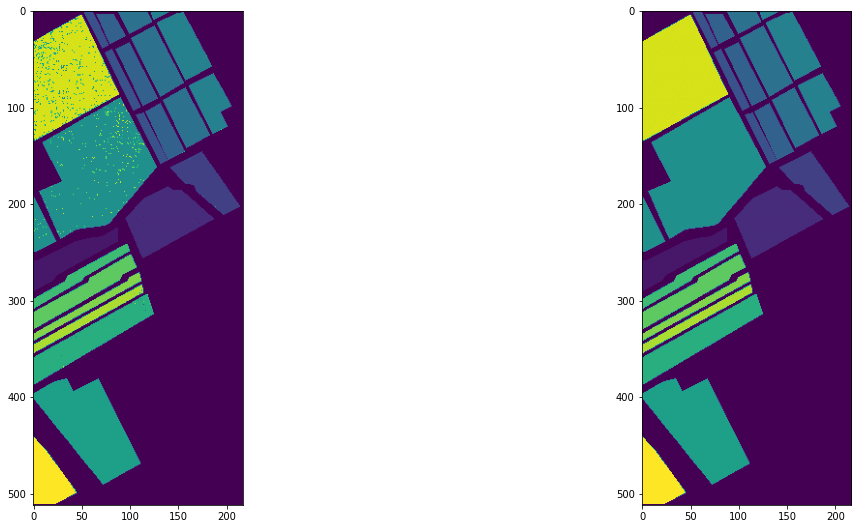

In [99]:
plot_two_figures(salinas_preds_img, salinas_label_img, figsize=(20, 20))

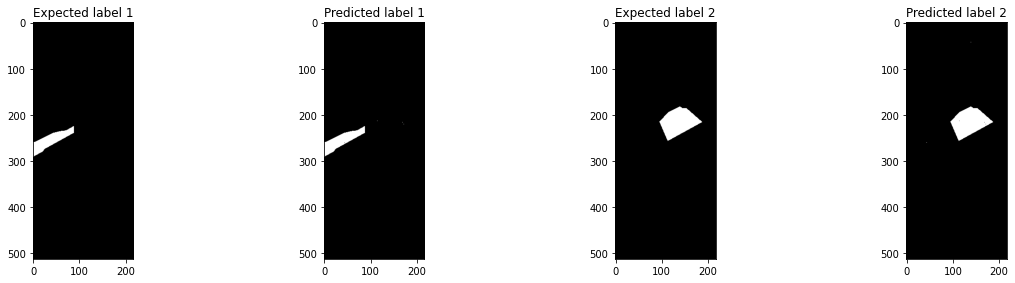

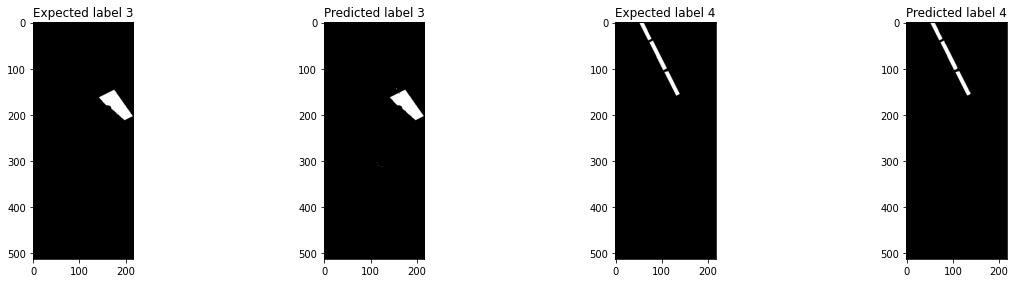

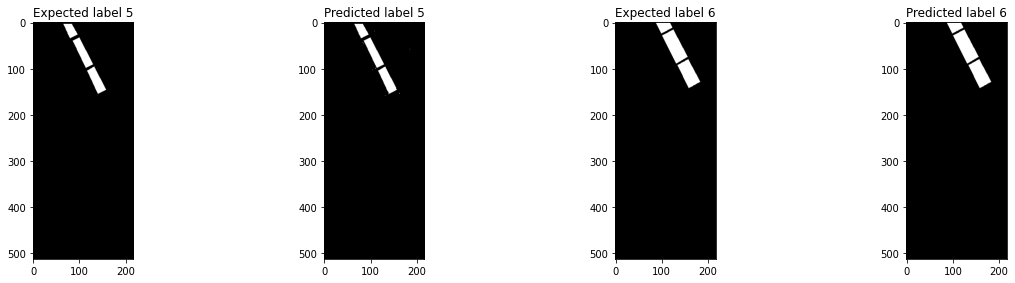

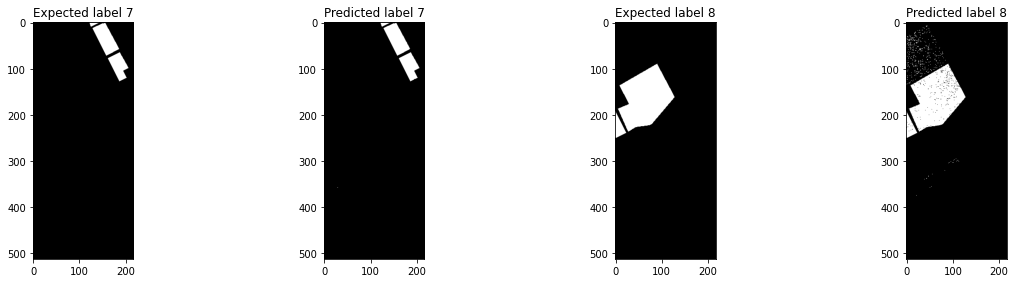

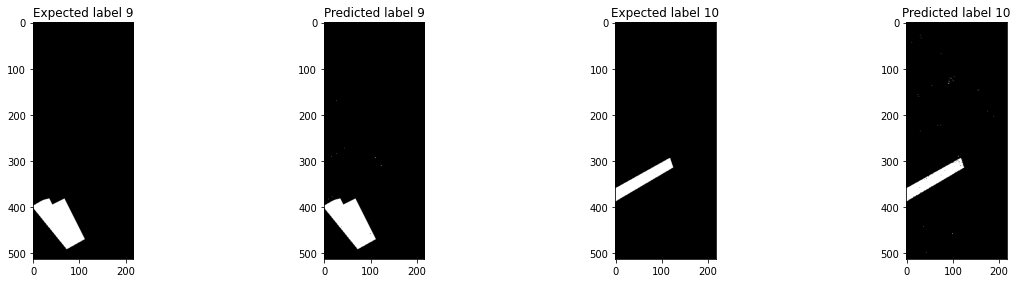

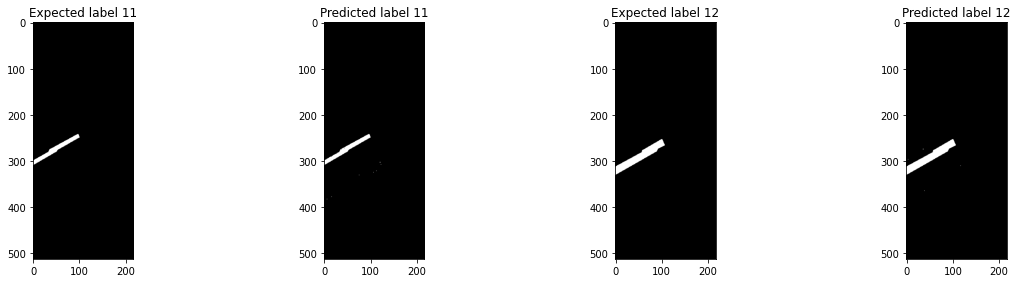

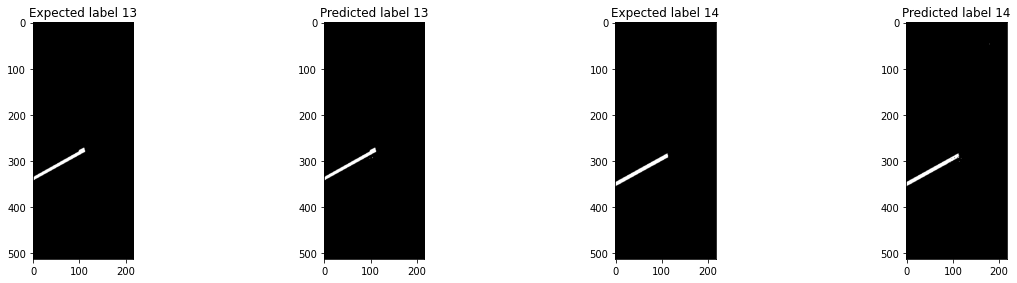

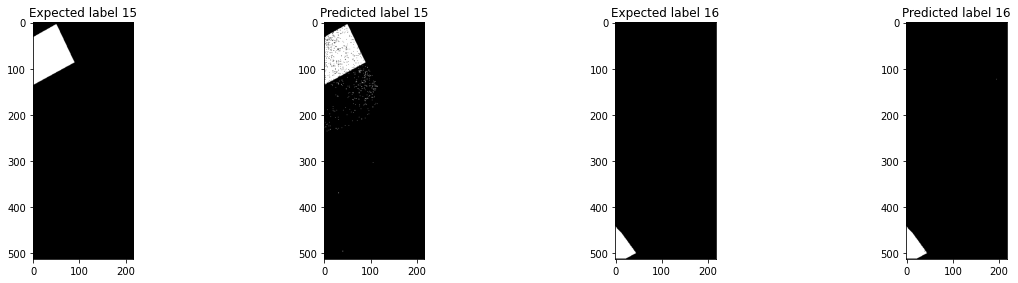

In [110]:
plot_each_labels(salinas_label_img, salinas_preds_img, n_cluster_salinas, figsize=(20, 20), cmap='gray')

In [101]:
indiana_preds_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))
indiana_label_img = np.zeros((indiana_img.shape[0] * indiana_img.shape[1]))

In [102]:
indiana_preds_img[X_indiana_idx] = preds_indiana + 1
indiana_preds_img = indiana_preds_img.reshape((indiana_img.shape[0], indiana_img.shape[1]))

In [103]:
indiana_label_img[X_indiana_idx] = indiana_labels
indiana_label_img = indiana_label_img.reshape((indiana_img.shape[0], indiana_img.shape[1]))

Number samples 46: 
34 used for training
12 used for testing


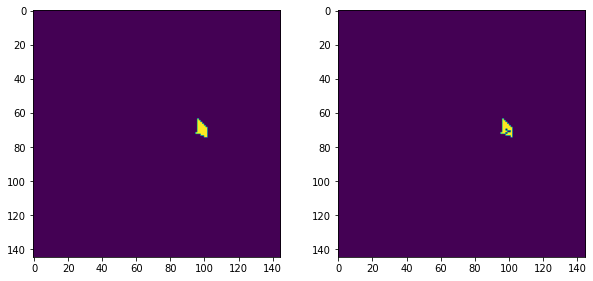

In [129]:
print("Number samples {}: ".format(indiana_labels[indiana_labels== 1].size))
print("{} used for training".format(y_train_indiana_labels[y_train_indiana_labels==0].size))
print("{} used for testing".format(y_test_indiana_labels[y_test_indiana_labels==0].size))

plot_two_figures(get_label(indiana_label_img, 1),get_label(indiana_preds_img, 1))

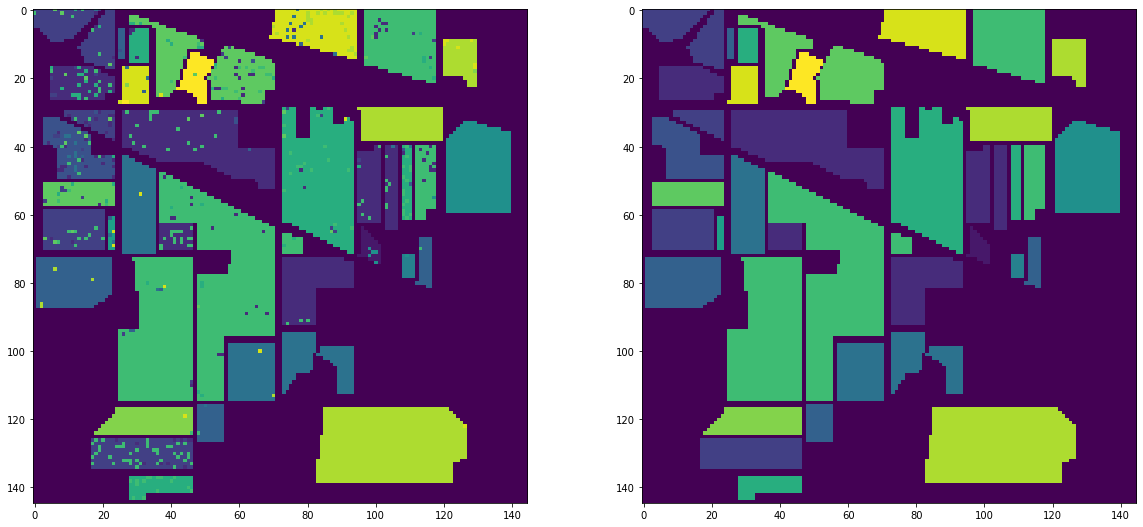

In [104]:
plot_two_figures(indiana_preds_img, indiana_label_img, figsize=(20, 20))

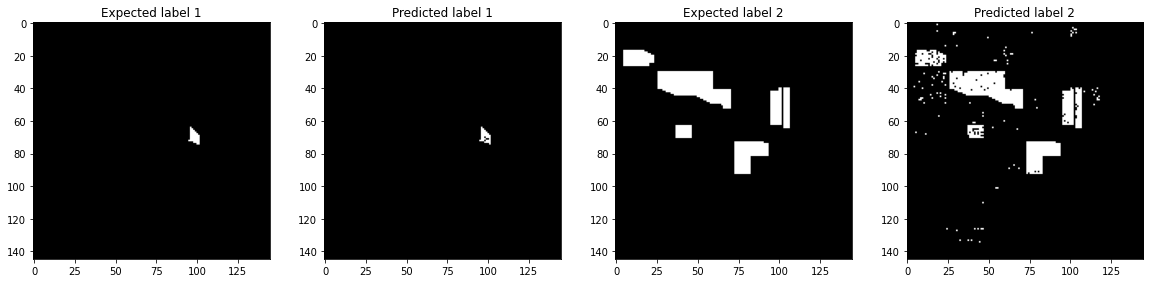

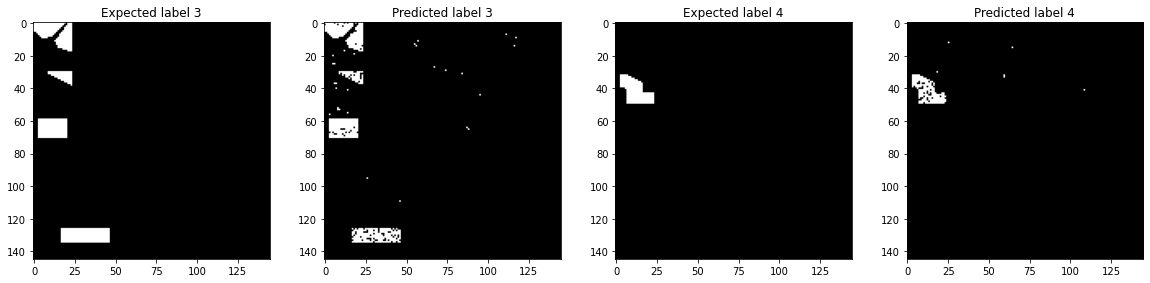

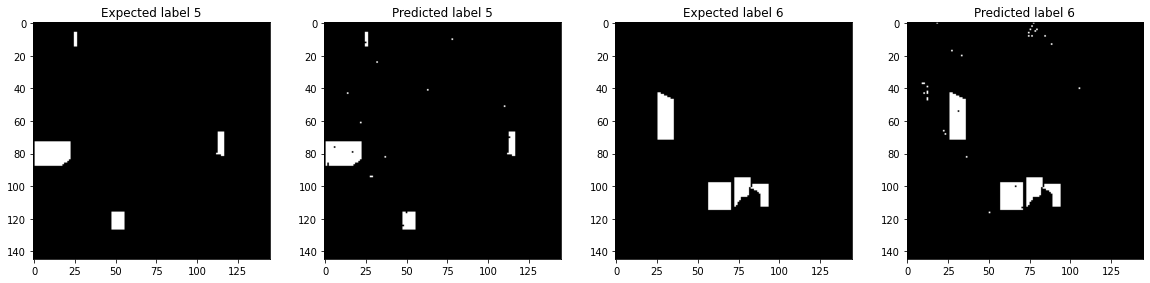

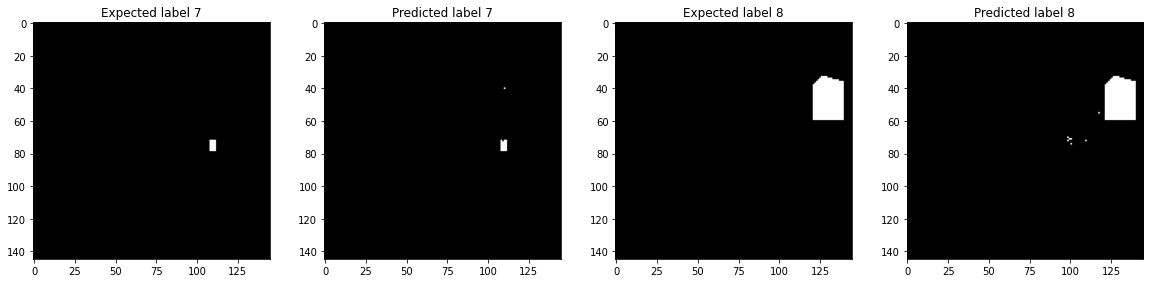

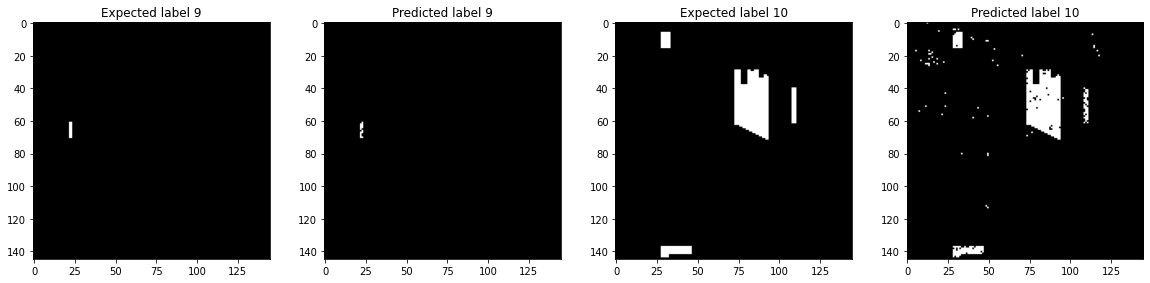

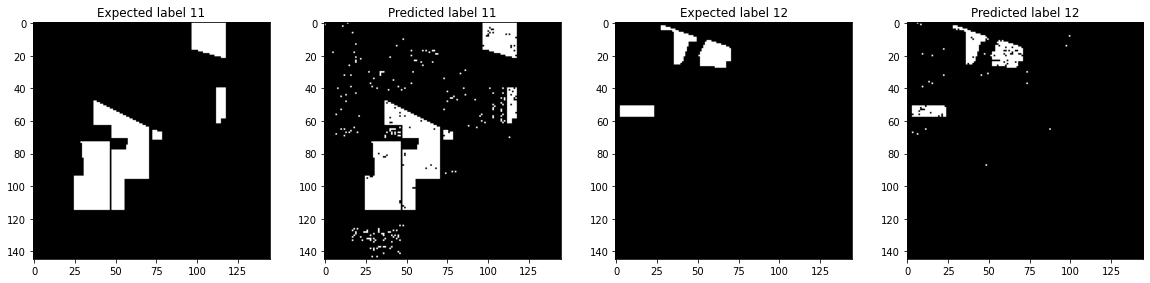

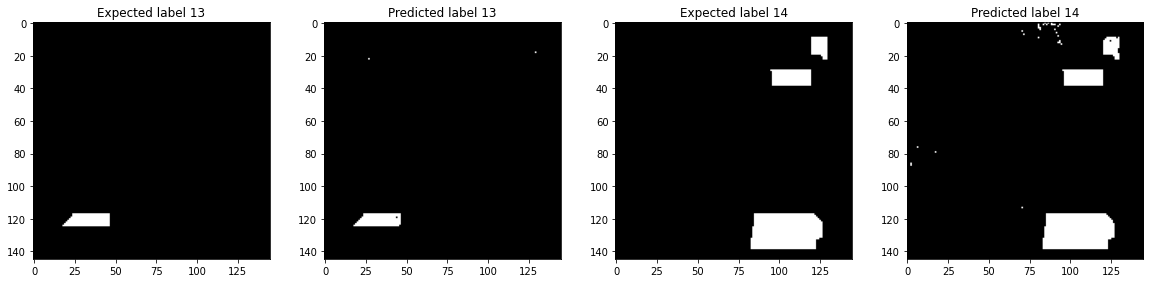

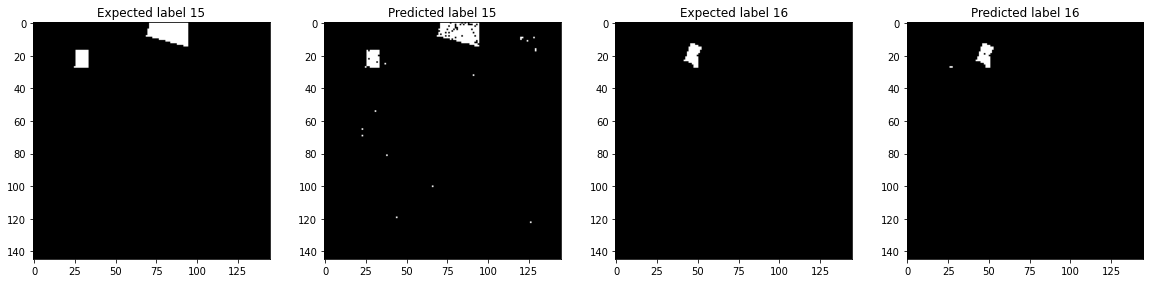

In [105]:
plot_each_labels(indiana_label_img, indiana_preds_img, n_cluster_indiana, figsize=(20, 20), cmap='gray')

In [106]:
indiana_labels.shape

(10249,)

In [107]:
preds_indiana.shape

(10249,)

In [108]:
print(classification_report(indiana_label_img.flatten(), indiana_preds_img.flatten()))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10776
         1.0       1.00      0.89      0.94        46
         2.0       0.93      0.94      0.94      1428
         3.0       0.96      0.88      0.92       830
         4.0       0.97      0.83      0.90       237
         5.0       0.98      0.98      0.98       483
         6.0       0.97      1.00      0.98       730
         7.0       0.96      0.96      0.96        28
         8.0       0.99      1.00      0.99       478
         9.0       1.00      0.75      0.86        20
        10.0       0.95      0.94      0.94       972
        11.0       0.93      0.98      0.95      2455
        12.0       0.96      0.90      0.93       593
        13.0       0.99      0.99      0.99       205
        14.0       0.98      0.99      0.98      1265
        15.0       0.96      0.89      0.92       386
        16.0       0.98      0.99      0.98        93

    accuracy              

In [109]:
print(classification_report(salinas_label_img.flatten(), salinas_preds_img.flatten()))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56975
         1.0       1.00      1.00      1.00      2009
         2.0       1.00      1.00      1.00      3726
         3.0       1.00      1.00      1.00      1976
         4.0       1.00      0.99      1.00      1394
         5.0       1.00      1.00      1.00      2678
         6.0       1.00      1.00      1.00      3959
         7.0       1.00      1.00      1.00      3579
         8.0       0.96      0.97      0.97     11271
         9.0       1.00      1.00      1.00      6203
        10.0       0.99      0.99      0.99      3278
        11.0       0.99      0.99      0.99      1068
        12.0       1.00      1.00      1.00      1927
        13.0       1.00      1.00      1.00       916
        14.0       1.00      0.99      0.99      1070
        15.0       0.96      0.94      0.95      7268
        16.0       1.00      1.00      1.00      1807

    accuracy              